# GIF Animation Generator using LangGraph and DALL-E

## Overview
This project demonstrates the creation of a GIF animation generator that leverages the power of large language models (LLMs) and image generation AI. By combining LangGraph for workflow management, GPT-4 for text generation, and DALL-E for image creation, we've developed a system that can produce custom GIF animations based on user prompts.

## Motivation
In the era of AI-driven content creation, there's a growing demand for tools that can automate and simplify complex creative processes. This project aims to showcase how various AI technologies can be integrated to create a seamless workflow that transforms a simple text prompt into a dynamic visual story. By doing so, we're exploring the potential of AI in creative fields and providing a tool that could be valuable for content creators, educators, and enthusiasts alike.

## Key Components
1. **LangGraph**: Orchestrates the overall workflow, managing the flow of data between different stages of the process.
2. **GPT-4 (via LangChain)**: Generates detailed descriptions, plots, and image prompts based on the initial user query.
3. **DALL-E 3**: Creates high-quality images based on the generated prompts.
4. **Python Imaging Library (PIL)**: Assembles the individual images into a GIF animation.
5. **Asynchronous Programming**: Utilizes `asyncio` and `aiohttp` for efficient parallel processing of image generation and retrieval.

## Method
The GIF generation process follows these high-level steps:

1. **Character/Scene Description**: Based on the user's input query, the system generates a detailed description of the main character or scene.

2. **Plot Generation**: Using the character description and initial query, a 5-step plot is created, outlining the progression of the animation.

3. **Image Prompt Creation**: For each step of the plot, a specific image prompt is generated, ensuring consistency across the frames.

4. **Image Generation**: DALL-E 3 is used to create images based on each prompt.

5. **GIF Assembly**: The generated images are compiled into a GIF animation.

Throughout this process, LangGraph manages the flow of information between steps, ensuring that the output of each stage is appropriately fed into the next. The use of asynchronous programming allows for efficient parallel processing, particularly during the image generation and retrieval phases.

## Conclusion
This GIF Animation Generator demonstrates the potential of combining different AI technologies to create a powerful, user-friendly tool for content creation. By automating the process from text prompt to visual animation, it opens up new possibilities for storytelling, education, and entertainment. 

The modular nature of the system, facilitated by LangGraph, allows for easy updates or replacements of individual components. This makes the project adaptable to future advancements in language models or image generation technologies.

While the current implementation focuses on creating simple 5-frame GIFs, the concept could be extended to create longer animations, incorporate user feedback at intermediate stages, or even integrate with other media types. As AI continues to evolve, tools like this will play an increasingly important role in bridging the gap between human creativity and machine capabilities.

## Setup and Imports

Import necessary libraries and set up the environment.

In [9]:
import os
from typing import TypedDict, Annotated, Sequence, List
from langgraph.graph import Graph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from openai import OpenAI
from PIL import Image
import io
from IPython.display import display, Image as IPImage

from langchain_core.runnables.graph import MermaidDrawMethod

import asyncio
import aiohttp
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Initialize OpenAI client
client = OpenAI()

## Define Data Structures

Define the structure for the graph state using TypedDict.

In [10]:
class GraphState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage], "The messages in the conversation"]
    query: Annotated[str, "Input query describing the character and scene"]
    plot: Annotated[str, "Generated plot for the GIF"]
    character_description: Annotated[str, "Detailed description of the main character or object"]
    image_prompts: Annotated[List[str], "List of prompts for each frame"]
    image_urls: Annotated[List[str], "List of URLs for generated images"]
    gif_data: Annotated[bytes, "GIF data in bytes"]

# Initialize the language model
llm = ChatOpenAI(model="gpt-4")

## Define Graph Functions

Define the functions that will be used in the LangGraph workflow.

In [11]:
async def get_image_data(session, url: str):
    """Fetch image data from a given URL."""
    async with session.get(url) as response:
        if response.status == 200:
            return await response.read()
    return None

def generate_character_description(state: GraphState) -> GraphState:
    """Generate a detailed description of the main character or scene."""
    query = state["query"]
    response = llm.invoke([HumanMessage(content=f"Based on the query '{query}', create a detailed description of the main character, object, or scene. Include specific details about appearance, characteristics, and any unique features. This description will be used to maintain consistency across multiple images.")])
    state["character_description"] = response.content
    return state

def generate_plot(state: GraphState) -> GraphState:
    """Generate a 5-step plot for the GIF animation."""
    query = state["query"]
    character_description = state["character_description"]
    response = llm.invoke([HumanMessage(content=f"Create a short, 5-step plot for a GIF based on this query: '{query}' and featuring this description: {character_description}. Each step should be a brief description of a single frame, maintaining consistency throughout. Keep it family-friendly and avoid any sensitive themes.")])
    state["plot"] = response.content
    return state

def generate_image_prompts(state: GraphState) -> GraphState:
    """Generate specific image prompts for each frame of the GIF."""
    plot = state["plot"]
    character_description = state["character_description"]
    response = llm.invoke([HumanMessage(content=f"""Based on this plot: '{plot}' and featuring this description: {character_description}, generate 5 specific, family-friendly image prompts, one for each step. Each prompt should be detailed enough for image generation, maintaining consistency, and suitable for DALL-E. 

Always include the following in EVERY prompt to maintain consistency:
1. A brief reminder of the main character or object's key features
2. The specific action or scene described in the plot step
3. Any relevant background or environmental details

Format each prompt as a numbered list item, like this:
1. [Your prompt here]
2. [Your prompt here]
... and so on.""")])
    
    prompts = []
    for line in response.content.split('\n'):
        if line.strip().startswith(('1.', '2.', '3.', '4.', '5.')):
            prompt = line.split('.', 1)[1].strip()
            prompts.append(f"Create a detailed, photorealistic image of the following scene: {prompt}")
    
    if len(prompts) != 5:
        raise ValueError(f"Expected 5 prompts, but got {len(prompts)}. Please try again.")
    
    state["image_prompts"] = prompts
    return state

async def create_image(prompt: str, retries: int = 3):
    """Generate an image using DALL-E based on the given prompt."""
    for attempt in range(retries):
        try:
            response = await asyncio.to_thread(
                client.images.generate,
                model="dall-e-3",
                prompt=prompt,
                size="1024x1024",
                quality="standard",
                n=1,
            )
            return response.data[0].url
        except Exception as e:
            if attempt == retries - 1:
                print(f"Failed to generate image for prompt: {prompt}")
                print(f"Error: {str(e)}")
                return None
            await asyncio.sleep(2)  # Wait before retrying

async def create_images(state: GraphState) -> GraphState:
    """Generate images for all prompts in parallel."""
    image_prompts = state["image_prompts"]
    tasks = [create_image(prompt) for prompt in image_prompts]
    image_urls = await asyncio.gather(*tasks)
    state["image_urls"] = image_urls
    return state

async def create_gif(state: GraphState) -> GraphState:
    """Create a GIF from the generated images."""
    image_urls = state["image_urls"]
    images = []
    async with aiohttp.ClientSession() as session:
        tasks = [get_image_data(session, url) for url in image_urls if url]
        image_data_list = await asyncio.gather(*tasks)
    
    for img_data in image_data_list:
        if img_data:
            images.append(Image.open(io.BytesIO(img_data)))
    
    if images:
        gif_buffer = io.BytesIO()
        images[0].save(gif_buffer, format='GIF', save_all=True, append_images=images[1:], duration=1000, loop=0)
        state["gif_data"] = gif_buffer.getvalue()
    else:
        state["gif_data"] = None
    return state

## Set Up LangGraph Workflow

Define the LangGraph workflow by adding nodes and edges.

In [12]:
workflow = Graph()

workflow.add_node("generate_character_description", generate_character_description)
workflow.add_node("generate_plot", generate_plot)
workflow.add_node("generate_image_prompts", generate_image_prompts)
workflow.add_node("create_images", create_images)
workflow.add_node("create_gif", create_gif)

workflow.add_edge("generate_character_description", "generate_plot")
workflow.add_edge("generate_plot", "generate_image_prompts")
workflow.add_edge("generate_image_prompts", "create_images")
workflow.add_edge("create_images", "create_gif")
workflow.add_edge("create_gif", END)

workflow.set_entry_point("generate_character_description")

app = workflow.compile()

## Display Graph Structure

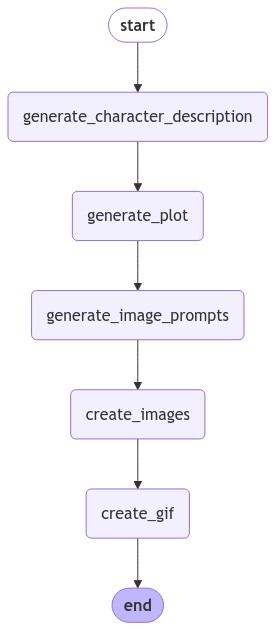

In [13]:
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run Workflow Function

Define a function to run the workflow and display results.

In [14]:
async def run_workflow(query: str):
    """Run the LangGraph workflow and display results."""
    initial_state = {
        "messages": [],
        "query": query,
        "plot": "",
        "character_description": "",
        "image_prompts": [],
        "image_urls": [],
        "gif_data": None
    }

    try:
        result = await app.ainvoke(initial_state)

        print("Character/Scene Description:")
        print(result["character_description"])

        print("\nGenerated Plot:")
        print(result["plot"])

        print("\nImage Prompts:")
        for i, prompt in enumerate(result["image_prompts"], 1):
            print(f"{i}. {prompt}")

        print("\nGenerated Image URLs:")
        for i, url in enumerate(result["image_urls"], 1):
            print(f"{i}. {url}")

        if result["gif_data"]:
            print("\nGIF generated successfully. Use the next cell to display or save it.")
        else:
            print("\nFailed to generate GIF.")
        
        return result
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

## Execute Workflow

Run the workflow with a sample query.

In [ ]:
query = "A cat wearing a top hat and monocle, sitting at a desk and writing a letter with a quill pen."
result = await run_workflow(query)

## Display and Save GIF

Display the generated GIF and provide an option to save it.

In [ ]:
if result and result["gif_data"]:
    # Display the GIF
    display(IPImage(data=result["gif_data"], format='gif'))
    
    # Ask if the user wants to save the GIF
    save_gif = input("Do you want to save the GIF? (yes/no): ").lower().strip()
    if save_gif == 'yes':
        filename = input("Enter the filename to save the GIF (e.g., output.gif): ").strip()
        if not filename.endswith('.gif'):
            filename += '.gif'
        with open(filename, 'wb') as f:
            f.write(result["gif_data"])
        print(f"GIF saved as {filename}")
    else:
        print("GIF not saved.")
else:
    print("No GIF data available to display or save.")

![Cat_GIF_agent](../images/langgraph_agent_cat_animation.gif)